<a href="https://colab.research.google.com/github/surya-aiml20/Pneumonia-Identification-from-Medical-Imaging/blob/main/pneumonia1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Chest X-ray dataset/chest x-ray.zip"  # replace with actual name
extract_path = "/content/chest_xray"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted.")

Dataset extracted.


In [ ]:
import os

for dirpath, dirnames, filenames in os.walk(extract_path):
    print(f"{dirpath} contains {len(filenames)} files")


/content/chest_xray contains 0 files
/content/chest_xray/chest_xray contains 0 files
/content/chest_xray/chest_xray/chest_xray contains 1 files
/content/chest_xray/chest_xray/chest_xray/test contains 1 files
/content/chest_xray/chest_xray/chest_xray/test/NORMAL contains 234 files
/content/chest_xray/chest_xray/chest_xray/test/PNEUMONIA contains 390 files
/content/chest_xray/chest_xray/chest_xray/val contains 1 files
/content/chest_xray/chest_xray/chest_xray/val/NORMAL contains 9 files
/content/chest_xray/chest_xray/chest_xray/val/PNEUMONIA contains 9 files
/content/chest_xray/chest_xray/chest_xray/train contains 1 files
/content/chest_xray/chest_xray/chest_xray/train/NORMAL contains 1342 files
/content/chest_xray/chest_xray/chest_xray/train/PNEUMONIA contains 3876 files
/content/chest_xray/chest_xray/test contains 0 files
/content/chest_xray/chest_xray/test/NORMAL contains 234 files
/content/chest_xray/chest_xray/test/PNEUMONIA contains 390 files
/content/chest_xray/chest_xray/val cont

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(extract_path, 'chest_xray', 'train')
test_dir = os.path.join(extract_path, 'chest_xray', 'test')

# Data augmentation for training
train_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2,
                               rotation_range=20,
                               horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("best_pneumonia_model.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.8520 - loss: 0.3393
Epoch 1: val_accuracy improved from -inf to 0.87981, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 825ms/step - accuracy: 0.8523 - loss: 0.3387 - val_accuracy: 0.8798 - val_loss: 0.2626
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9311 - loss: 0.1741
Epoch 2: val_accuracy improved from 0.87981 to 0.89423, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 750ms/step - accuracy: 0.9311 - loss: 0.1740 - val_accuracy: 0.8942 - val_loss: 0.2330
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9369 - loss: 0.1591
Epoch 3: val_accuracy did not improve from 0.89423
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 752ms/step - accuracy: 0.9369 - loss: 0.1590 - val_accuracy: 0.8670 - val_loss: 0.3557
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9344 - loss: 0.1476
Epoch 4: val_accuracy did not improve from 0.89423
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 751ms/step - accuracy: 0.9344 - loss: 0.1476 - val_accuracy: 0.8750 - val_loss: 0.2649
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.9464 - loss: 0.1360
Epoch 5: val_accuracy did not improve from 0.89423
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 758ms/step - accuracy: 0.9464 - loss: 0.1360 - val_accuracy: 0.8782 - val_loss: 0.3219
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9513 - loss: 0.1192
Epoch 6: va

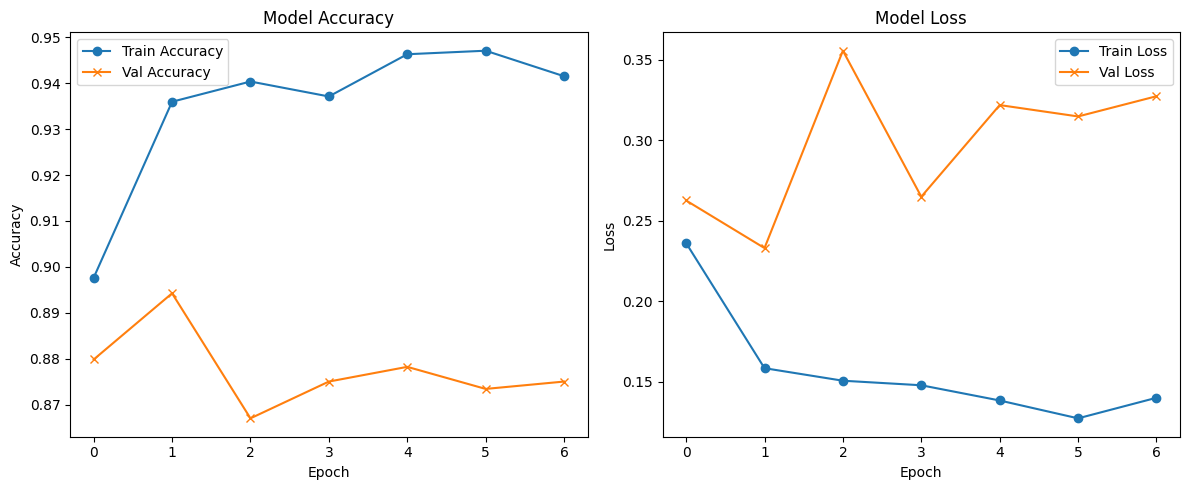

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("best_pneumonia_model.h5")

# Evaluate on test data
loss, acc = best_model.evaluate(test_data)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")
print(f"❌ Test Loss: {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 428ms/step - accuracy: 0.8911 - loss: 0.2468

✅ Test Accuracy: 89.42%
❌ Test Loss: 0.2330


In [ ]:
!pip install tensorflow pillow


In [ ]:
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving 0f94ecfe-2944-49ab-879d-ca04b9aef5a6.jpeg to 0f94ecfe-2944-49ab-879d-ca04b9aef5a6.jpeg
Uploaded file: 0f94ecfe-2944-49ab-879d-ca04b9aef5a6.jpeg


In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_pneumonia_model.h5")


In [ ]:
def predict(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)[0][0]
    result = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = prediction if result == "Pneumonia" else 1 - prediction
    print(f"\n🔎 Prediction: {result} ({confidence * 100:.2f}% confidence)")


In [ ]:
# Example usage
image_path = list(uploaded.keys())[0]
predict(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

🔎 Prediction: Normal (99.16% confidence)


Saving n.jpeg to n.jpeg


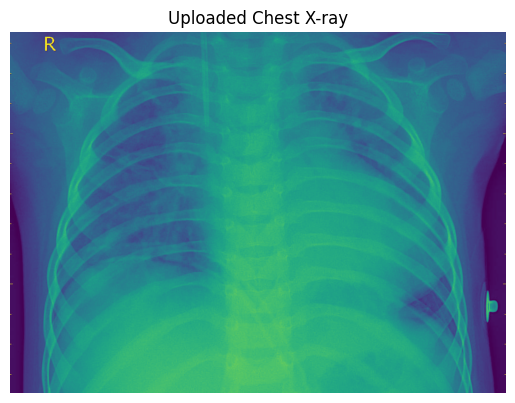

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


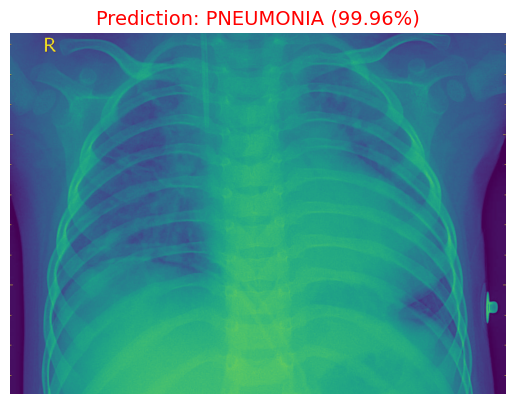

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image

# Upload image
uploaded = files.upload()

# Load the image
for fn in uploaded.keys():
    img_path = fn

# Display original image
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Chest X-ray")
plt.show()

# Preprocess image for prediction
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalize

# Load trained model
model = load_model("best_pneumonia_model.h5")

# Predict
prediction = model.predict(img_array)[0][0]
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
confidence = prediction if prediction > 0.5 else 1 - prediction

# Display prediction
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)", fontsize=14, color='green' if label == "NORMAL" else 'red')
plt.show()


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load the model
model = load_model("/content/drive/MyDrive/Chest X-ray dataset/best_pneumonia_model.h5")

# Define recommendation generator
def get_recommendation(label):
    if label == "NORMAL":
        return (
            "✅ No signs of pneumonia detected.\n\n"
            "**Recommendations:**\n"
            "- Maintain a healthy lifestyle.\n"
            "- Get regular check-ups.\n"
            "- Avoid smoking or exposure to pollutants.\n"
            "- If you feel unwell (cough, fever, chest pain), consult a doctor."
        )
    else:
        return (
            "⚠️ Signs of pneumonia detected.\n\n"
            "**Recommendations:**\n"
            "- Immediately consult a healthcare provider.\n"
            "- Complete prescribed antibiotic course.\n"
            "- Get adequate rest and stay hydrated.\n"
            "- Avoid contact with others to prevent spread.\n"
            "- Follow up with a chest X-ray if advised."
        )

# Prediction + Recommendations
def predict_pneumonia(img):
    # Resize and preprocess image
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Prediction
    prediction = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Combine prediction and recommendation
    output = f"🩺 **Prediction**: {label} ({confidence*100:.2f}%)\n\n"
    output += get_recommendation(label)

    return output

# Gradio Interface
interface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil"),
    outputs=gr.Markdown(),
    title="Chest X-Ray Pneumonia Detection with Medical Recommendations",
    description="Upload a chest X-ray image to check for pneumonia and receive helpful medical advice."
)

# Launch app
interface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9ef5001cc1aa198cbd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
